# COMP15212 Lab 5 "Experiment"

## Goals
I will attempt to evaluate the behaviours of three types of cache: LRU, Cyclic and Random. I will study them individually and in comparison to each other.

## Expectations
I would expect the ordering of efficiency to be as follows:
### LRU > Cyclic = Random >>> Memory

## Methods
The base storage of each type of cache is 4, but it will be changed for some tests.

* First, I will create a number of uniformly randomly generated tests. Here I expect all cache models to fail miserably as the memory gets large because they will have a chance of $\frac{size}{range}$ to get a hit.
* Second, I will sample addresses from a uniform distribution. Technically, this won't be close to the calls that a real program would make. For example, the first few values are very unlikely to be used towards the end of a large application.
* Third, I will account for the previous weakness by moving the mean around but keeping the variance constant.
* Finally, I will simulate multiple programs running on the same processor.


## Getting started

Useful imports:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from memory import *
import numpy as np
from random import randint
import math
from scipy.ndimage.filters import gaussian_filter1d as gaussian_filter

import warnings
warnings.filterwarnings("ignore")

Instantiating each type of memory & creating useful methods:

In [2]:
mem = Memory()
cyclic = CyclicCache()
lru = LRUCache()
rand = RandomCache()

In [3]:
names = ['LRU', 'Cyclic', 'Random']
caches = {'LRU': lru, 'Cyclic': cyclic, 'Random': rand}

In [4]:
def clear():
    global caches
    caches['LRU'] = LRUCache(size=caches['LRU'].cache_size)
    caches['Cyclic'] = CyclicCache(size=caches['Cyclic'].cache_size)
    caches['Random'] = RandomCache(size=caches['Random'].cache_size)

clear()

In [5]:
def resize(size=4):
    global caches
    caches['LRU'] = LRUCache(size=size)
    caches['Cyclic'] = CyclicCache(size=size)
    caches['Random'] = RandomCache(size=size)

resize()

In [6]:
def lookup(location):
    global caches
    for cache in caches.values():
        cache.lookup(location)

lookup(0)

## Testing
### Uniform Distribution Tests
Preliminary examples

In [7]:
S = 4 # size of cache
N = 10000 # number of tests
R = 10 # range of memory

resize(S)
for i in range(N):
    new_sample = randint(1, R)
    lookup(new_sample)
for name in names:
    efficiency = round((N-caches[name].get_hit_count())/N*100, 2)
    print(f"{name} efficiency for S={S} and R={R}: {efficiency}%")

S = 13
N = 100000
R = 100
resize(S)
for i in range(N):
    new_sample = randint(1, R)
    lookup(new_sample)
for name in names:
    efficiency = round((N-caches[name].get_hit_count())/N*100, 2)
    print(f"{name} efficiency for S={S} and R={R}: {efficiency}%")

LRU efficiency for S=4 and R=10: 40.21%
Cyclic efficiency for S=4 and R=10: 40.24%
Random efficiency for S=4 and R=10: 40.02%
LRU efficiency for S=13 and R=100: 13.06%
Cyclic efficiency for S=13 and R=100: 13.09%
Random efficiency for S=13 and R=100: 13.03%


Estimating the ideal cache size depending on memory size

In [8]:
N = 10000 # number of tests
max_R = 1000 # maximum range of memory

results = {'Cyclic': [], 'LRU': [], 'Random': []}
ranges = list(range(1, max_R, int(max_R/20)))
sizes = list(range(1, max_R, int(max_R/20)))

for R in ranges:
    best_mem_hc = {name: N for name in names}
    best_size = {name: 0 for name in names}
    for S in sizes:
        resize(S)
        for i in range(N):
            sample = randint(1, R)
            lookup(sample)
        for name in names:
            if caches[name].get_hit_count() < best_mem_hc[name]:
                best_mem_hc[name] = caches[name].get_hit_count()
                best_size[name] = S
    for name in names:
        results[name].append(best_size[name])
        
print("This took a while!")

This took a while!


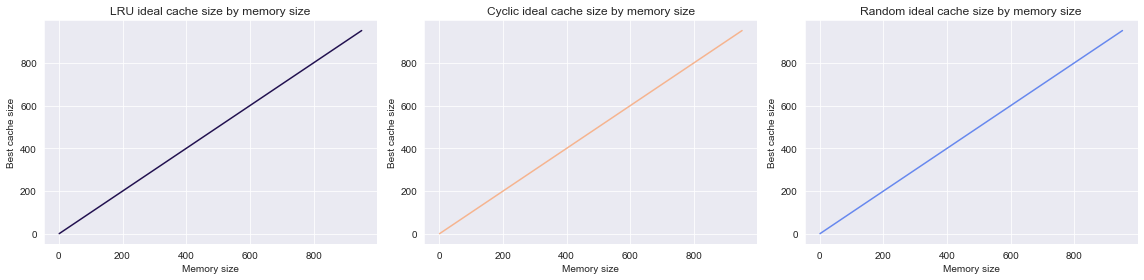

In [59]:
palettes = ['magma', 'rocket_r', 'coolwarm']
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4))

for idx in range(3):
    sns.set_palette(palettes[idx])
    plt.subplot(1, 3, idx+1)
    name = names[idx]
    res = results[name]

    sns.set_palette(palettes[idx])
    sns.lineplot(res, ranges)
    plt.title(name + " ideal cache size by memory size")
    plt.xlabel("Memory size")
    plt.ylabel("Best cache size")

plt.tight_layout()
plt.show()

As expected, the result of a uniform test with memory range $[0, R]$ and cache size $S$ yields the efficiency $\frac{S}{R}$ as $N \rightarrow \infty$. Testing the optimal cache size with this distribution will always result in size $S=R$. We will not get useful results with this approach.

## Tailored tests
To get an insight into how I might simulate real-life programs, I will first check the given test files.
### Visualising the given tests

In [61]:
text_files = ["in-10.txt", "in-20.txt", "in-40.txt", "in-100.txt", "in-1000.txt"]
values = dict([(int(text.split('-')[1].split('.')[0]), [int(x.strip()) for x in open(text, "r").read().split()]) for text in text_files])
sizes = [int(text.split('-')[1].split('.')[0]) for text in text_files]

values[sizes[1]]

[3, 1, 9, 2, 1, 2, 4, 4, 6, 9, 1, 2, 2, 7, 1, 2, 8, 5, 1, 7]

Finding the overall distribution of data

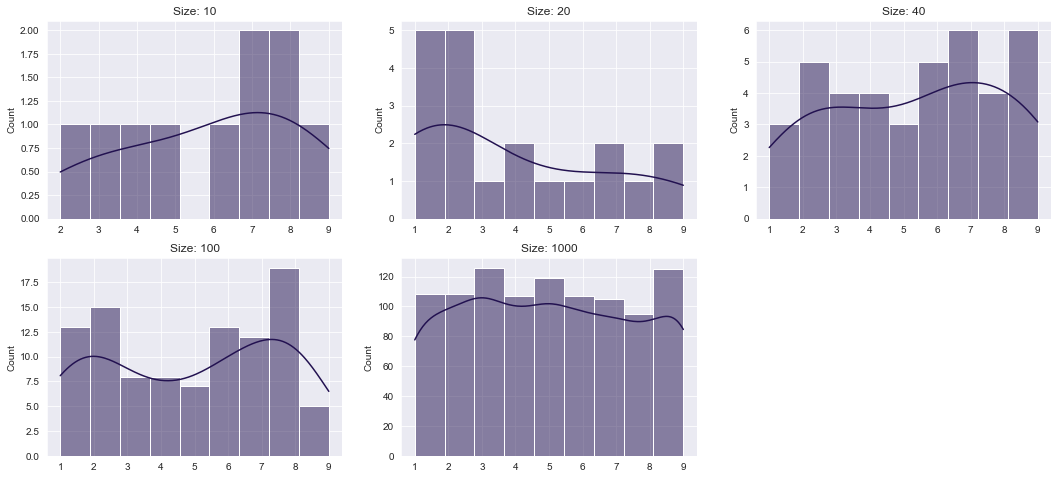

In [62]:
sns.set_palette("magma")
f, a = plt.subplots(2, 3, figsize=(18, 8))
a = a.ravel()

for idx in range(5):
    sns.histplot(values[sizes[idx]], ax=a[idx], bins=9, kde=True)
    a[idx].set_title("Size: " + str(sizes[idx]))

plt.delaxes(a[5])

Checking for spatial locality within the data, i.e. the difference between two consecutive addresses

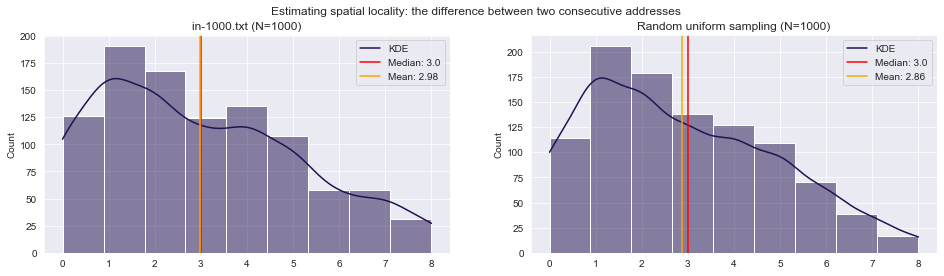

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle("Estimating spatial locality: the difference between two consecutive addresses")

titles = ['in-1000.txt', 'Random uniform sampling']
vs = [values[1000], [randint(1, 9) for i in range(1000)]]
for i in range(2):
    v = vs[i]
    differences = np.array([abs(v[i+1] - v[i]) for i in range(len(v)-1)])
    mean = np.mean(differences)
    median = np.median(differences)
    
    sns.histplot(differences, ax=ax[i], bins=9, kde=True)
    ax[i].axvline(median, color='red')
    ax[i].axvline(mean, color='orange')
    ax[i].legend(['KDE', f'Median: {round(median, 2)}', f'Mean: {round(mean, 2)}'])
    ax[i].set_title(titles[i] + ' (N=1000)')

Checking for temporal locality of the data, i.e. the time it takes to see a given address again

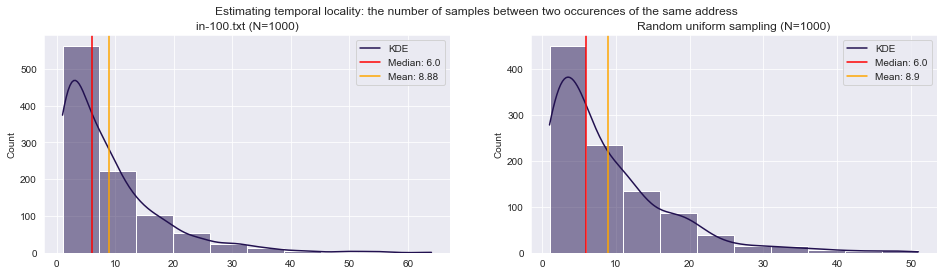

In [67]:
def delta_next(v, i):
    try:
        return v.index(v[i], i+1) - i
    except:
        return -1

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle("Estimating temporal locality: the number of samples between two occurences of the same address")

titles = ['in-100.txt', 'Random uniform sampling']
vs = [values[1000], [randint(1, 9) for i in range(1000)]]
for i in range(2):
    v = vs[i]
    differences = np.array([delta_next(v, i) for i in range(len(v))])
    differences = differences[differences != -1]
    mean = np.mean(differences)
    median = np.median(differences)
    
    sns.histplot(differences, ax=ax[i], bins=10, kde=True)
    ax[i].axvline(median, color='red')
    ax[i].axvline(mean, color='orange')
    ax[i].legend(['KDE', f'Median: {round(median, 2)}', f'Mean: {round(mean, 2)}'])
    ax[i].set_title(titles[i] + ' (N=1000)')

The given tests seem to be random uniform distributions, which means they are not very informative. In reality they would not be uniform, but rather closer to Gaussian distributions for which the mean moves around with time. I have not found any estimations of this online, so I will simulate this in three ways:


* Repeated random samples from a Gaussian distribution
* Repeated random samples from a Gaussian distribution that depends on the previous sample
* Simulated 'programs', or nodes that jump around with their own uniform distribution


A very useful sampling function from a normal distribution with mean $mu$, standard deviation $sigma$ and range $[0, R]$

In [164]:
def sample(mu, sigma, R):
    new_sample = np.random.normal(loc=mu, scale=sigma)
    if(new_sample < 0 or new_sample > R): 
        return sample(mu, sigma, R)
    else: return new_sample
print(sample(0, 1, 100))

0.7516128788388392


### Static Gaussian distribution sampling
I will repeatedly draw random samples $X$ from a Gaussian distribution with mean $\mu=\frac{R}{2}$ and standard deviation $\sigma=\frac{R}{20}$, where the range of the memory is $[0, R]$. These samples will be tested against various sizes of cache $S$.

In [123]:
R = 1000 # range of memory
mu = R/2 # mean of distribution
sigma = R/20 # standard deviation of distribution
N = 10000 # number of tests
sizes = list(range(1, R, int(R/50)))

samples = []
results = {name: [] for name in names}
for S in sizes:
    resize(S)
    for i in range(N):
        new_sample = sample(mu, sigma, R)
        samples.append(new_sample)
        lookup(int(new_sample))
    for name in names:
        results[name].append((N-caches[name].get_hit_count())/N*100)
print("Finished calculating!")

Finished calculating!


Visualising the density of data against the memory range

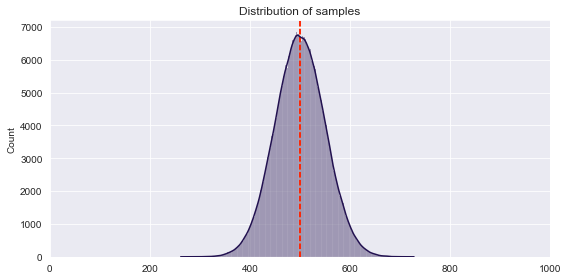

In [124]:
sns.set_palette('magma')
plt.figure(figsize=(8, 4))
plt.axvline(np.mean(samples), color='orange', linestyle='--')
plt.axvline(np.median(samples), color='red', linestyle='--')
sns.histplot(samples, kde=True)
plt.xlim(0, R)
plt.title("Distribution of samples")
plt.tight_layout()
plt.show()

Visualising the cache efficiency

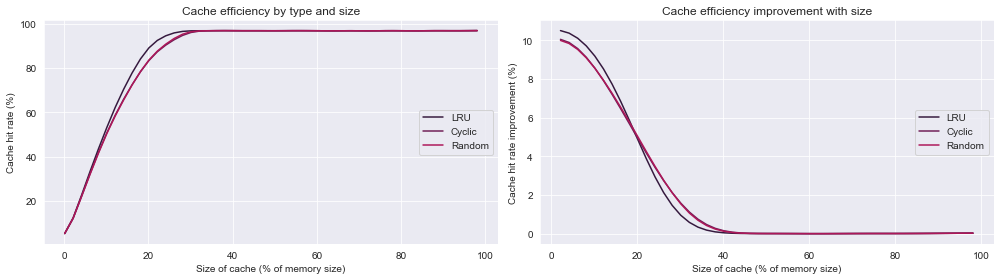

In [125]:
plt.figure(figsize=(14, 4))
sns.set_palette("rocket")

plt.subplot(1, 2, 1)
for name in names:
    smoothed_bar = gaussian_filter(results[name], sigma=1)
    sns.lineplot([size/R*100 for size in sizes], smoothed_bar)
plt.legend(names, loc="center right")
plt.title("Cache efficiency by type and size")
plt.xlabel("Size of cache (% of memory size)")
plt.ylabel("Cache hit rate (%)")

plt.subplot(1, 2, 2)
for name in names:
    differences = [results[name][i] - results[name][i-1] for i in range(1, len(results[name]))]
    smoothed_bar = gaussian_filter(differences, sigma=3)
    sns.lineplot([size/R*100 for size in sizes][1:], smoothed_bar)
plt.legend(names, loc="center right")
plt.title("Cache efficiency improvement with size")
plt.xlabel("Size of cache (% of memory size)")
plt.ylabel("Cache hit rate improvement (%)")

plt.tight_layout()
plt.show()

The graphs never reach $100\%$ efficiency because the first occurence of an address will always result in a memory hit. It appears that LRU gets a slight edge on the higher end of the spike, but it is far smaller than I assumed. The 'sweet spot' of efficiency seems to be slightly below $\frac{R}{4}$ for all types of cache. This is naturally proportional to our chosen variation. If we double the standard deviation, the optimal size rises to about $\frac{R}{2}$, as plotted below.

![](img/cache_efficiency_big_s.png)

Also, increasing memory size by a factor of 10 yields more closely tied results, indicating that LRU's edge is near-constant and therefore the improvement is minimal for real-life applications.

![](img/cache_efficiency_big_mem.png)

### Dynamic Gaussian distribution sampling
Repeated random samples $X_1$ will be drawn from a Gaussian distribution with mean $\mu=X_0$ and standard deviation $\sigma=\frac{R}{100}$, where $X_0$ is the previous sample and $[0, R]$ is the memory range. These will be tested against various sizes of cache $S$.

In [225]:
R = 1000 # range of memory
X1 = R/2 # current test
N = 10000 # number of tests
sigma = R/100 # standard deviation of distribution

sizes = range(1, R, int(R/50))
results = {name: [] for name in names}

# for this test, sampling is computationally expensive 
# and has high variation, so it will be done only once 
# and all sizes will be tested against the same batch
samples = []
for i in range(N):
        X0 = X1
        mu = X0
        X1 = sample(mu, sigma, R)
        samples.append(X1)
for S in sizes:
    resize(S)
    for i in samples:
        lookup(int(i))
    for name in names:
        results[name].append((N-caches[name].get_hit_count())/N)
print("All done!")

All done!


Visualising the distribution of tests

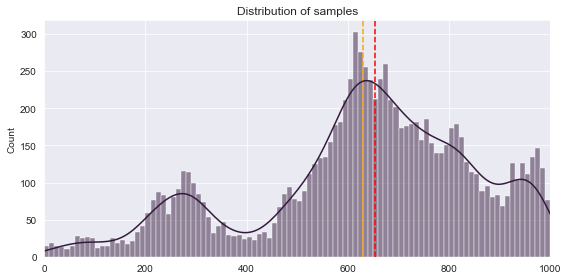

In [226]:
plt.figure(figsize=(8, 4))
plt.axvline(np.mean(samples), color='orange', linestyle='--')
plt.axvline(np.median(samples), color='red', linestyle='--')
sns.histplot(samples, kde=True, bins=100)
plt.xlim(0, R)
plt.title("Distribution of samples")
plt.tight_layout()
plt.show()

Visualising the efficiency of caches

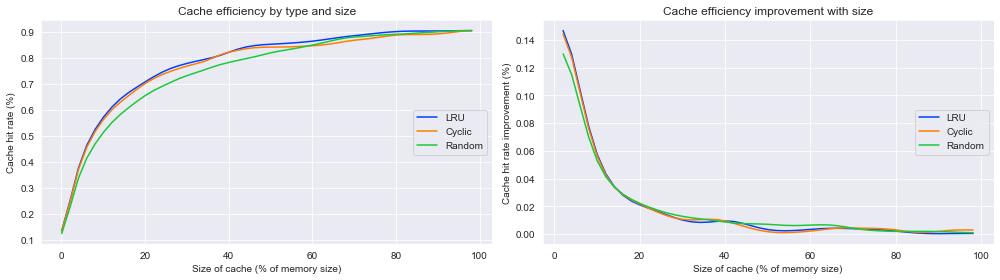

In [229]:
plt.figure(figsize=(14, 4))
sns.set_palette("bright")

plt.subplot(1, 2, 1)
for name in names:
    smoothed_bar = gaussian_filter(results[name], sigma=1)
    sns.lineplot([size/R*100 for size in sizes], smoothed_bar)
plt.legend(names, loc="center right")
plt.title("Cache efficiency by type and size")
plt.xlabel("Size of cache (% of memory size)")
plt.ylabel("Cache hit rate (%)")

plt.subplot(1, 2, 2)
for name in names:
    differences = [results[name][i] - results[name][i-1] for i in range(1, len(results[name]))]
    smoothed_bar = gaussian_filter(differences, sigma=2)
    sns.lineplot([size/R*100 for size in sizes][1:], smoothed_bar)
plt.legend(names, loc="center right")
plt.title("Cache efficiency improvement with size")
plt.xlabel("Size of cache (% of memory size)")
plt.ylabel("Cache hit rate improvement (%)")

plt.tight_layout()
plt.show()

For this model, the difference between LRU and Cyclic is diminished. Surprisingly enough, Random appears to be slightly behing Cyclic. The hit rate spike fades over a longer range of sizes. An good choice might be to stop at $0.7$ efficiency, which is around $\frac{R}{5}$.

### Simulated programs
For this test, a number of independent 'programs' will run in parallel, as follows: a simulated CPU has pre-programmed 'time slices', which allow a process to run a set number of address requests. Afterwards, the next program will run their allowed slice, and so on, until the last process is reached. At this point, our imaginary scheduler brings back the first process. This cycle repeats $N$ times (tests). The entire model will be tested against various cache sizes $S$.

In [270]:
R = 1000 # range of memory
R_progs = 25 # range that a process can access
N = 100 # number of scheduler cycles
N_progs = 50 # number of processes running
CPU_slice = 10 # number of addresses per time slice

# for this test, sampling is computationally expensive 
# and has high variation, so it will be done only once 
# and all sizes will be tested against the same batch
programs = [randint(50, R-50) for i in range(N_progs)]
samples = [{program: [] for program in programs} for i in range(N)]
flattened_samples = []
for cycle in range(N):
    for program in programs:
        for instruction in range(CPU_slice):
            new_sample = int(program + randint(0, R_progs) - R_progs/2)
            samples[cycle][program].append(new_sample)
            flattened_samples.append(new_sample)

results = {name: [] for name in names}
sizes = range(1, R, int(R/50))
for S in sizes:
    resize(S)
    for cycle in range(N):
        for program in programs:
            for instruction in range(CPU_slice):
                lookup(samples[cycle][program][instruction])
    for name in names:
        value =(N*N_progs*CPU_slice-caches[name].get_hit_count())/(N*N_progs*CPU_slice)*100
        results[name].append(value)
print("Finished!")

Finished!


Visualising the address distribution

Text(0.5, 1.0, 'Distribution of program calls')

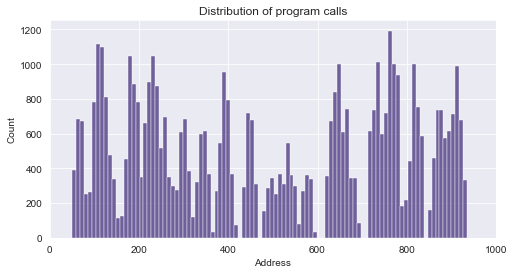

In [271]:
sns.set_palette('viridis')
plt.figure(figsize=(8, 4))
sns.histplot(flattened_samples, bins=100)
plt.xlim(0, R)
plt.xlabel("Address")
plt.title("Distribution of program calls")

Visualising the resulting efficiencies

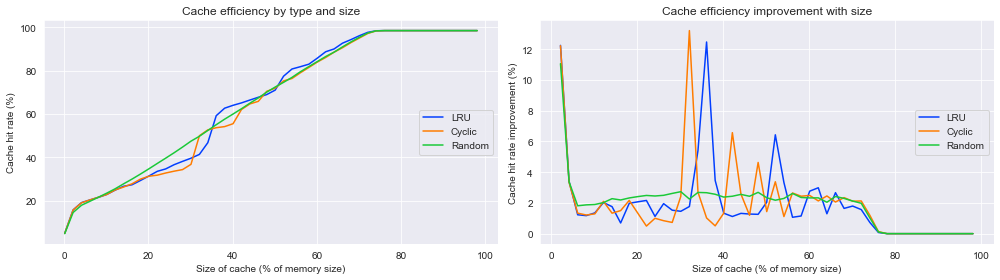

In [273]:
plt.figure(figsize=(14, 4))
sns.set_palette("bright")

plt.subplot(1, 2, 1)
for name in names:
    smoothed_bar = gaussian_filter(results[name], sigma=0.5)
    sns.lineplot([size/R*100 for size in sizes], smoothed_bar)
plt.legend(names, loc="center right")
plt.title("Cache efficiency by type and size")
plt.xlabel("Size of cache (% of memory size)")
plt.ylabel("Cache hit rate (%)")

plt.subplot(1, 2, 2)
for name in names:
    differences = [results[name][i] - results[name][i-1] for i in range(1, len(results[name]))]
    smoothed_bar = gaussian_filter(differences, sigma=0.5)
    sns.lineplot([size/R*100 for size in sizes][1:], smoothed_bar)
plt.legend(names, loc="center right")
plt.title("Cache efficiency improvement with size")
plt.xlabel("Size of cache (% of memory size)")
plt.ylabel("Cache hit rate improvement (%)")

plt.tight_layout()
plt.show()

For the final test, it is apparent that the cache types' efficiency varies significantly with input and size. Large spikes for LRU and Cyclic can be observed in the range $[\frac{1}{3}R, \frac{1}{2}R]$, which are not results of random variation as I was able to consistently replicate them with a large number of tests. However, the overall link between efficiency and cache size is once again almost linear. Tweaking the number of programs, the size of CPU time slices, or the range that a program can access will distort the graph in various ways, but the linearity is present through all values and the performances' ordering remains the same.

# Conclusion

Various methods of testing have been employed to compare three caching strategies: Least-recently-used, Cyclic, and Random. I expected LRU to overtake the other two.

This expectation was refuted. Having performed a number of tests, I conclude that **LRU $\approx$ Cyclic $\approx$ Random**, and that their hit rates increase logarithmically as the size of the cache approaches the size of the memory. For my test numbers, the greatest spike in efficiency was $0-20\%$ of the memory size. Depending on the test method, the higher end of this range may result in up to $80\%$ cache hit rate. 

I believe that the decision of which caching method to employ is, ultimately, context-specific. Oftentimes, the various caching strategies present little to non-existent differences, and so they may largely be interchangeable.